# BBC news dataset with linear SVM

The documents from the bbc news dataset are classified into their topics (business, entertainment, politics, sport, tech) using a support vector machine with linear kernel. TF-IDFs are used as features. A comparison is made between using all tokens (from the default tokenizer) as well as only the ones with the highest coefficients in the trained SVM. 

## Reading the data

In [ ]:
import os
import glob
data_dir = "./data"

bbc_fulltext_dir = data_dir + "/bbc-fulltext"
y = []
corpus = []
for topic in os.listdir(bbc_fulltext_dir):
    topic_dir = bbc_fulltext_dir + "/" + topic
    if os.path.isdir(topic_dir): # there might also be files in this directory, which we dont want to read.
        for file in glob.glob(topic_dir + "/*.txt"):
            with open(file, encoding="cp1252") as article: # weird encoding
                y += [topic]
                corpus += [article.read()]

## Preprocessing

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
import re

# This is the default tokenization function from sklearn.
token_pattern = re.compile(r"(?u)\b\w\w+\b") 
vectorizer = TfidfVectorizer(min_df=1, tokenizer=lambda doc: [token for token in token_pattern.findall(doc)])
X = vectorizer.fit_transform(corpus)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

len(vectorizer.get_feature_names()) # Number of Tokens

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


29421

## Training

In [18]:
svm = LinearSVC(C=1000000.0) # Large C --> Lower margin hyperplane is preferred if it improves misclassification rate
svm.fit(X_train, y_train)

LinearSVC(C=1000000.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Testing

In [19]:
from sklearn.metrics import confusion_matrix

pred = svm.predict(X_test)

# Output the hit-rate and the confusion matrix for each model
print(svm.score(X_test, y_test))
print(confusion_matrix(pred, y_test))

0.9730337078651685
[[ 83   1   2   0   1]
 [  0  78   0   0   1]
 [  2   1  92   0   0]
 [  1   1   0 107   0]
 [  0   1   1   0  73]]


## Extract and plot "most important" tokens for each of the classes
The "most important" tokens are those with the highest absolute coefficients. There might be some overlap between the classes, which is why a set is used. For `take_n = 10`, for example, the number of tokens is `73`, instead of `5 * 2 * 10 = 100`.

In [25]:
def extract_highest_coefficient_tokens(clf, feature_names, take_n=10, plot=False):
    highest_coefficient_tokens = set()
    for label, label_coefs in zip(clf.classes_, clf.coef_):    
        top_positive_coefficients = np.argsort(label_coefs)[-take_n:]
        top_negative_coefficients = np.argsort(label_coefs)[:take_n]
        top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
        highest_coefficient_tokens.update(set(feature_names[top_coefficients]))
        if plot:
            plt.figure(figsize=(15, 5))
            plt.title(label)
            plt.bar(np.arange(2 * take_n), label_coefs[top_coefficients])
            plt.xticks(np.arange(0, 2 * take_n), feature_names[top_coefficients], rotation=60)
            plt.show()
        
    return highest_coefficient_tokens

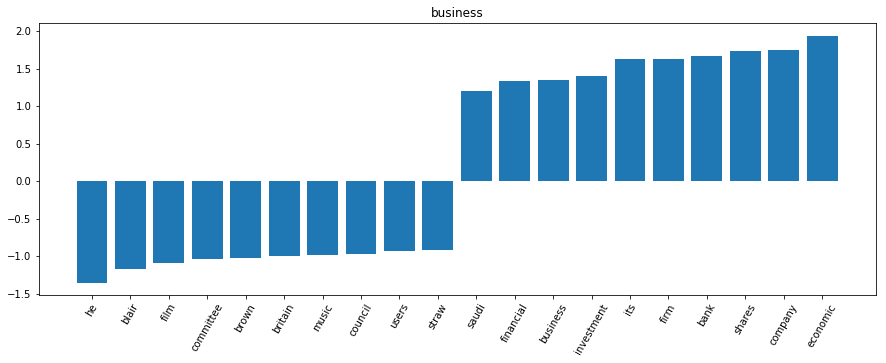

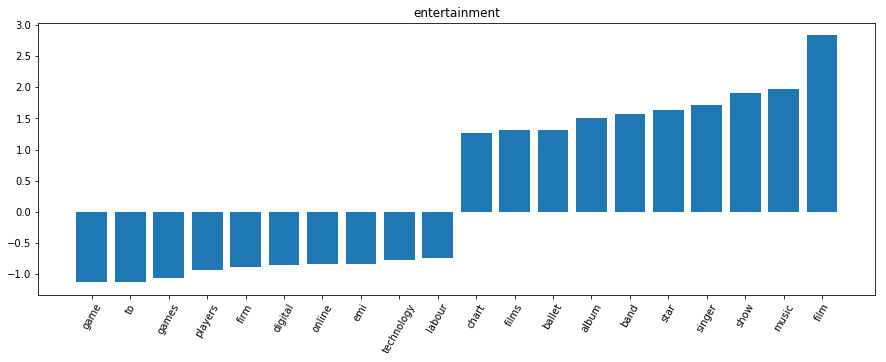

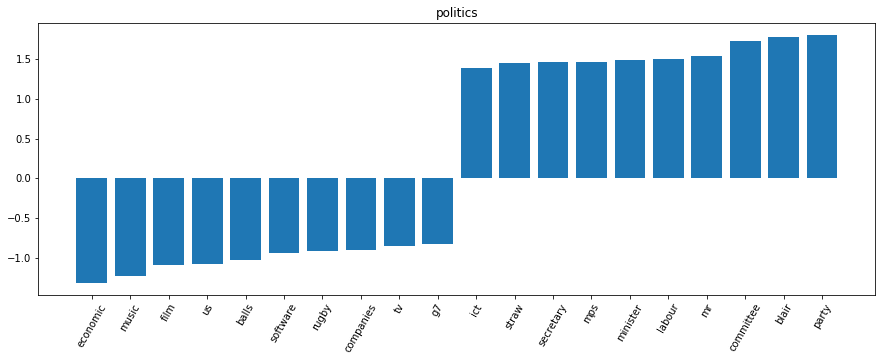

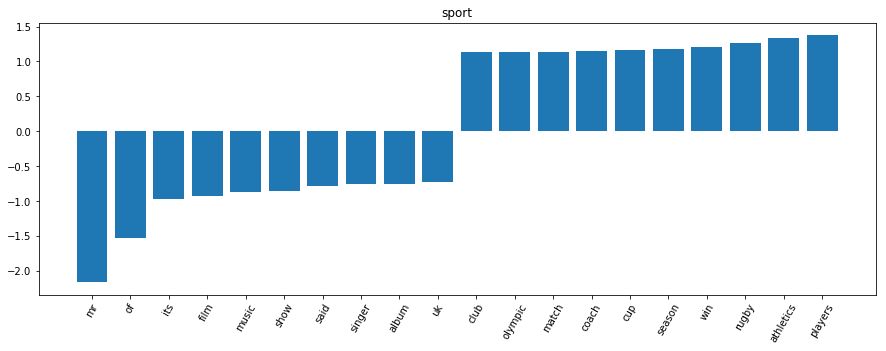

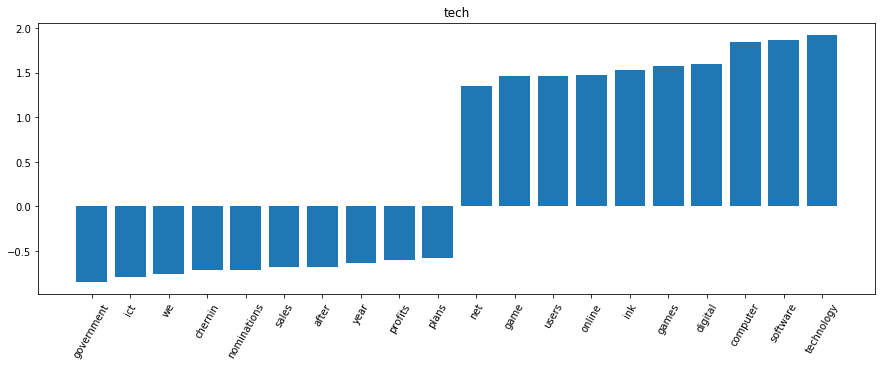

73

In [26]:
import numpy as np
import matplotlib.pyplot as plt
most_important_labels = extract_highest_coefficient_tokens(svm, np.array(vectorizer.get_feature_names()), plot=True)
len(most_important_labels)

## Only use most important tokens
Next, only the `n` "most important" (as defined above) tokens are used and the accuracy is plotted for various `n` and compared to the accuracy when using all `29421` tokens (remember: the terms in TF-IDF are the tokens in this case). 

In [27]:
def accuracy_with_tokens(allowed_tokens):
    # This is the default tokenization function from sklearn, except we only allow specific tokens.
    vectorizer = TfidfVectorizer(min_df=1, tokenizer=lambda doc: [token for token in token_pattern.findall(doc) 
                                                                  if token in allowed_tokens]) 
    X = vectorizer.fit_transform(corpus)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    svm = LinearSVC(C=1000000.0) # Large C --> Lower margin hyperplane is preferred if it improves misclassification rate
    svm.fit(X_train, y_train)
    
    return svm.score(X_test, y_test)

In [29]:
import pandas as pd
results = []
unique_tokens_tested = [1,2,3,5,6,7] + [i*4 for i in range(1,25)] # [1, 10,20,30,40,50,60,70, 80, 90, 100]
for take_n in unique_tokens_tested:
    most_important_labels = extract_highest_coefficient_tokens(svm, np.array(vectorizer.get_feature_names()), take_n=take_n)
    accuracy = accuracy_with_tokens(most_important_labels)    
    results += [[take_n, len(most_important_labels), accuracy]]

    
pd.DataFrame(results, columns=["Tokens per class", "Unique Tokens", "Accuracy"])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


,Tokens per class,Unique Tokens,Accuracy
0,1,9,0.426966
1,2,17,0.647191
2,3,25,0.768539
3,5,38,0.847191
4,6,44,0.858427
5,7,51,0.865169
6,4,31,0.833708
7,8,60,0.894382
8,12,87,0.930337
9,16,110,0.928090


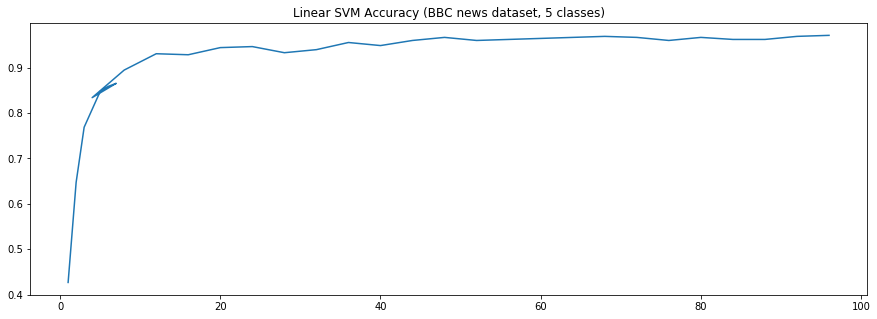

In [31]:
plt.figure(figsize=(15, 5))
plt.title("Linear SVM Accuracy (BBC news dataset, 5 classes)")
plt.plot([tokens_per_class for tokens_per_class, unique_tokens, accuracy in results], [accuracy for tokens_per_class, unique_tokens, accuracy in results])
plt.show()

## Conclusion

The 87 most important tokens already lead to an accuracy of 93% using a linear SVM. The remaining 29334 tokens only increase accuracy by 4%. **This is merely supposed to give a feeling for what "kind" of tokens can be used to best identify relevant news articles**. It can be observed that there is close to no overlap between these tokens and the classes that current object recognition algorithms detect. This will be the next area of work.